In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv
/kaggle/input/tabpfn-019-whl/tabpfn-0.1.9-py3-none-any.whl
/kaggle/input/tabpfn-019-whl/prior_diff_real_checkpoint_n_0_epoch_42.cpkt
/kaggle/input/tabpfn-019-whl/prior_diff_real_checkpoint_n_0_epoch_100.cpkt


In [2]:
!pip install -q /kaggle/input/tabpfn-019-whl/tabpfn-0.1.9-py3-none-any.whl

In [3]:
!mkdir /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/tabpfn-019-whl/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Invitro Cell Research: 56 useable features with some meta data that I won't investigate until later in the process. 55 of these features are numeric with one being categorical. This means I will be using Kendalls correlation and mutual information for vetting. I will being with bringing the data in and taking a first look at balance seen in the dependent variable and see if any balancing needs to occur.

In [4]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import catboost as cb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from numpy import where
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier as RF, VotingClassifier
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler
from tabpfn import TabPFNClassifier
from xgboost import XGBClassifier as xgb, DMatrix

In [5]:
#import the data
Train = pd.read_csv(r'/kaggle/input/icr-identify-age-related-conditions/train.csv')
Test = pd.read_csv(r'/kaggle/input/icr-identify-age-related-conditions/test.csv')
Train['Class'].describe()

count    617.000000
mean       0.175041
std        0.380310
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Class, dtype: float64

In [6]:
Test.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It is a bit weighted towards the negative class. So I will transform the data to better fit and then enact SMOTE

In [7]:
import pandas as pd

# Assuming you already have a DataFrame named 'df'

null_counts = Train.isnull().sum()
null_df = pd.DataFrame(null_counts, columns=['Null Count'])
null_df = null_df.reset_index()
null_df.columns = ['Feature', 'Null Count']
null_df = null_df[null_df['Null Count'] > 0]

print(null_df.sort_values(by = 'Null Count'))

   Feature  Null Count
33      DU           1
44      FC           1
48      FL           1
56      GL           1
16      CB           2
50      FS           2
17      CC           3
13      BQ          60
41      EL          60


In [8]:
Train.drop('EL', axis=1, inplace=True)
Train.drop('BQ', axis=1, inplace=True)
Train.dropna(inplace = True)

In [9]:
#Make lists to section Train Dataset
Columns = Train.columns
numeric_features = list(Columns)
Columns = list(Columns)
Columns.remove('Id')
numeric_features.remove('Id')
numeric_features.remove('EJ')
numeric_features.remove('Class')
categorical_features = ['EJ']
target = ['Class']
features = numeric_features + categorical_features

In [10]:
#Define Transformer
power = PowerTransformer(method='yeo-johnson', standardize=True)

#Transform numeric_features
for x in numeric_features:
    Train[x] = power.fit_transform(Train[[x]])
    Test[x] = power.fit_transform(Test[[x]])

Train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,-1.059237,-0.007851,-0.696800,0.084921,-0.496314,-3.880135,-0.592580,-0.100712,1.114652,...,0.913302,0.957782,-0.913446,-1.149877,-0.778168,-0.914525,-0.966419,0.730314,-0.903768,1
1,007255e47698,-1.647365,-1.517595,-0.696800,0.659607,-0.496314,-0.876979,-0.592580,0.716781,-0.837728,...,-1.137198,-1.355371,0.943309,-1.589525,-0.778168,1.041964,-0.139993,-0.327666,1.232095,0
2,013f2bd269f5,0.441624,-0.269592,-0.696800,0.516171,-0.496314,0.684579,-0.592580,0.571122,-0.837728,...,0.952519,-0.093214,1.695489,1.564329,0.081215,0.416396,-0.261752,-0.213971,-0.828497,0
3,043ac50845d5,-0.728639,0.343420,1.227268,1.342882,-0.496314,-0.842407,-0.592580,0.184549,-0.837728,...,0.786319,-1.355371,0.108811,-0.040244,-0.193569,-0.888797,0.906694,1.130556,-0.868058,0
4,044fb8a146ec,0.043991,0.302817,-0.696800,-0.532651,-0.496314,-0.680536,1.288298,-1.879265,1.939874,...,0.992289,3.175021,-0.730571,-0.317586,1.206247,0.045108,1.360930,-0.175970,-0.928513,1


In [11]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

#encode categorical variables
for x in categorical_features:
    Train[x] = label_encoder.fit_transform(Train[x])
    Test[x] = label_encoder.fit_transform(Test[x])

Train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,...,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,612.000000
mean,-8.707632e-18,5.950215e-17,1.259834e-09,4.789197e-16,6.193145e-09,-2.176908e-16,1.015890e-17,1.944704e-16,1.951961e-16,-4.382841e-16,...,2.060806e-16,4.194176e-16,2.539726e-16,-3.860383e-16,3.385179e-13,3.366951e-16,-5.166528e-16,3.483053e-16,-8.417377e-17,0.174837
std,1.000818e+00,1.000818e+00,1.000818e+00,1.000818e+00,1.000818e+00,1.000818e+00,1.000818e+00,1.000818e+00,1.000818e+00,1.000818e+00,...,1.000818e+00,1.000818e+00,1.000818e+00,1.000818e+00,1.000818e+00,1.000818e+00,1.000818e+00,1.000818e+00,1.000818e+00,0.380138
min,-2.375675e+00,-2.735726e+00,-6.967998e-01,-3.063893e+00,-4.963144e-01,-3.880135e+00,-5.925805e-01,-1.879265e+00,-8.377278e-01,-4.123727e+00,...,-1.137198e+00,-1.355371e+00,-1.112367e+00,-3.298426e+00,-7.781683e-01,-2.823519e+00,-3.087148e+00,-2.993032e+00,-1.035939e+00,0.000000
25%,-7.286389e-01,-5.378860e-01,-6.967998e-01,-7.337194e-01,-4.963144e-01,-5.696869e-01,-5.925805e-01,-5.041553e-01,-8.377278e-01,-5.511266e-01,...,-1.137198e+00,-1.355371e+00,-1.112367e+00,-6.740508e-01,-7.781683e-01,-7.133741e-01,-6.072809e-01,-7.248811e-01,-8.996166e-01,0.000000
50%,-8.864301e-02,-1.196471e-02,-6.967998e-01,-2.527826e-02,-4.963144e-01,-7.465052e-02,-5.925805e-01,5.437498e-02,-8.377278e-01,4.701369e-02,...,2.706445e-01,1.883262e-01,-3.609595e-02,-1.113701e-02,-7.781683e-01,-1.408745e-02,1.481227e-02,-6.145149e-03,-7.085086e-01,0.000000
75%,7.464458e-01,5.801187e-01,1.042381e+00,7.207977e-01,-4.963144e-01,5.592118e-01,3.905307e-01,6.021570e-01,1.034098e+00,6.212784e-01,...,8.000472e-01,7.131557e-01,8.704882e-01,6.894026e-01,9.895721e-01,7.105660e-01,6.260317e-01,6.913964e-01,1.232095e+00,0.000000
max,2.440317e+00,5.891747e+00,1.961278e+00,2.535166e+00,2.252824e+00,5.757410e+00,2.315862e+00,4.889387e+00,1.980229e+00,5.087069e+00,...,2.568755e+00,3.254750e+00,2.298039e+00,4.607642e+00,1.868466e+00,2.813032e+00,3.686596e+00,2.434742e+00,1.232095e+00,1.000000


It only removed 3 cases so I will now add in SMOTE to try and even it out more

In [12]:
#Creating the remove_list
remove_list = []

Now that the Data is prepped, it is time to begin feature selection!

In [13]:
#Finding Mutual information for Categorical variables

#Set up features and targets
X = Train[categorical_features]
y = Train[target]
y = y.values.ravel()

# Calculate mutual information
mi = mutual_info_classif(X, y)

combined_dict = {k: v for k, v in zip(categorical_features, mi)}

print(combined_dict)

{'EJ': 0.011681872019156048}


In [14]:
# Set up X and y for Kendall's correlation
X = Train[numeric_features]
y = Train[target]
y = y.values.ravel()

# Create a dataframe to store the correlation results
correlation_df = pd.DataFrame(columns=['Variable', 'Correlation', 'p-value'])

# Calculate Kendall's correlation coefficient for each independent variable
for var in numeric_features:
    correlation_coef, p_value = stats.kendalltau(X[var], y)
    if(p_value >= 0.05):
        correlation_df = pd.concat([correlation_df, pd.DataFrame({'Variable': [var],
                                                              'Correlation': [correlation_coef],
                                                              'p-value': [p_value]})], ignore_index=True)
        remove_list.append(var)

# Sort the dataframe by p-value in descending order
correlation_df_sorted = correlation_df.sort_values(by='p-value', ascending=False)

# Display the sorted dataframe
correlation_df_sorted.head(15)

,Variable,Correlation,p-value
8,CH,-0.000451,0.989193
19,GH,-0.000766,0.981512
13,EG,-0.002557,0.938350
16,FC,0.002567,0.938111
5,BR,-0.009381,0.777207
7,CF,-0.009664,0.770115
17,FS,0.014988,0.661558
4,BD,-0.016525,0.617162
3,AZ,0.018266,0.582782
18,GB,0.022857,0.489389


A large amount of variables failed the null hypothis or show any mutual information. They will be cut as a result

In [15]:
# Remove axed variables from features
features = [x for x in features if x not in remove_list]

# Remove axed variables from columns
Columns = [x for x in Columns if x not in remove_list]

#Use lists to rid usesless variables from data frame
Train = Train[Columns]

In [16]:
# Set up variables
X = Train[features]
y = Train[target]
y = y.values.ravel()

# Select the top 20 best features using mutual information
selector = SelectKBest(mutual_info_classif, k = 20)
selector.fit(X, y)

# Get the selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
features = [features[i] for i in selected_feature_indices]

In [17]:
#Now to use SMOTE and TomekLinks respectively
oversampling = SMOTE()
undersampling = TomekLinks()

X = Train[features]
y = Train[target]

#First TomekLinks to put some space between postive and negative outcomes
X, y = undersampling.fit_resample(X, y)

X, y = oversampling.fit_resample(X, y)

#Make a new train data frame
X_frame = pd.DataFrame(X)
y_frame = pd.DataFrame(y)
Train = pd.concat([X_frame, y_frame], axis = 1)

Train.describe()

,AB,AF,AM,AR,BC,BP,CC,CR,DA,DE,...,DU,EB,EE,EH,FD,FE,FL,FR,GL,Class
count,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,...,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000
mean,0.256828,0.263491,0.132715,0.124801,0.188178,0.107590,-0.142776,-0.243456,-0.208952,-0.149342,...,0.278209,0.149294,-0.157217,0.154914,0.129080,0.144910,0.218964,0.100540,-0.145298,0.500000
std,0.990154,1.023865,0.994790,1.072645,1.003500,0.980930,1.058976,1.034792,1.076528,1.060121,...,1.132862,0.896449,0.999876,1.092370,1.055697,1.049697,1.056747,1.054999,0.980926,0.500251
min,-2.375675,-2.735726,-3.063893,-0.496314,-0.837728,-3.494817,-4.067952,-3.546883,-3.221272,-2.991611,...,-0.945490,-1.474552,-2.416208,-0.982235,-1.102703,-3.269916,-1.137198,-1.355371,-1.035939,0.000000
25%,-0.499533,-0.351404,-0.569106,-0.496314,-0.837728,-0.416859,-0.749056,-0.893725,-0.914402,-0.905703,...,-0.945490,-0.345982,-0.894783,-0.982235,-1.102703,-0.510579,-1.137198,-0.960103,-0.942561,0.000000
50%,0.282811,0.250765,0.144988,-0.496314,0.190972,0.141729,-0.074406,-0.149414,-0.099656,-0.181799,...,0.268244,0.263157,-0.142796,-0.009075,0.257522,0.073758,0.548256,0.227891,-0.828000,0.500000
75%,1.042726,0.853838,0.799183,0.382057,1.156715,0.729018,0.483881,0.401992,0.490483,0.604121,...,1.510576,0.734281,0.497249,1.144491,1.056807,0.811950,1.092077,0.824761,1.232095,1.000000
max,2.440317,5.891747,2.535166,2.252824,1.980229,3.260211,4.345369,4.864356,4.832065,2.636287,...,1.976164,3.265555,3.374896,2.151418,2.664553,2.980242,2.568755,3.254750,1.232095,1.000000


Time to use a feature selection algorithim. I'm using RF and basing it on how RF decides to place feature importance.

In [18]:
#Defining inputs
X = Train[features]
y = Train[target]

# Convert y to a 1D array
y = y.values.ravel()

#Creating Estimator algo for feature importance
sel = SelectFromModel(RF(n_estimators = 100))
sel.fit(X, y)

#Getting names of selected features
selected_feat = X.columns[(sel.get_support())]

# Displaying feature importance for each variable
print(selected_feat)

Index(['AB', 'CR', 'DA', 'DU', 'FL', 'GL'], dtype='object')


Using a recursive feature selection algorithim with a simple logistic regression to decide on the number of features the KBest algo should pick from the list given above.

In [19]:
X = Train[selected_feat]
y = Train[target]
y = y.values.ravel()

min_features_to_select = 1  # Minimum number of features to consider
clf = LR()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 5


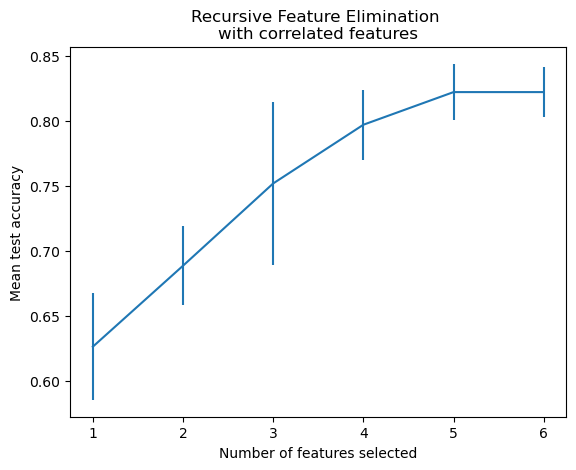

In [20]:
#plotting the accuracy of the classifier across feature numbers
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

Looks Promising! I'm going to through these into a Kbest selector to get the top 5 and then go from there!

In [21]:
#Define new features list
features = list(selected_feat)

# Set up variables
X = Train[features]
y = Train[target]
y = y.values.ravel()

# Select the top 9 best features using mutual information
selector = SelectKBest(mutual_info_classif, k= rfecv.n_features_)
selector.fit(X, y)

# Get the selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = [features[i] for i in selected_feature_indices]

# Print the list of selected features
print(selected_features)

['AB', 'CR', 'DU', 'FL', 'GL']


In [22]:
#Redfining Features again
features = selected_features
others = ['Id']

#Shaving Data Frames
Train = Train[features + target]
Test = Test[others + features]

#Checking Train with describe
Train.describe()

,AB,CR,DU,FL,GL,Class
count,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000
mean,0.256828,-0.243456,0.278209,0.218964,-0.145298,0.500000
std,0.990154,1.034792,1.132862,1.056747,0.980926,0.500251
min,-2.375675,-3.546883,-0.945490,-1.137198,-1.035939,0.000000
25%,-0.499533,-0.893725,-0.945490,-1.137198,-0.942561,0.000000
50%,0.282811,-0.149414,0.268244,0.548256,-0.828000,0.500000
75%,1.042726,0.401992,1.510576,1.092077,1.232095,1.000000
max,2.440317,4.864356,1.976164,2.568755,1.232095,1.000000


I'm now going to export the data so I can use it in a collab sheet and get better performance when features tuning my models. I will put code boxes to show how I achived this and import the models as well.

In [23]:
Train.to_csv('Invitro_train.csv', index = False)

Below I'm going to put my tuning code. I just didn't want to put it in the notebook to reduce possible error.

# Setting up X,y
X = Train.iloc[:, : -1]
y = Train['Class']

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reporting util for different optimizers
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers

    optimizer = a sklearn or a skopt optimizer
    X = the training set
    y = our target
    title = a string label for the experiment
    """
    start = time()

    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)

    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_

    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start,
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params
    
    # Setting the scoring function
scoring = make_scorer(f1_score)

# Setting the validation strategy
skf = StratifiedKFold(n_splits=7,
                      shuffle=True,
                      random_state=0)
cv_strategy = list(skf.split(X_train, y_train))

# Setting the basic classifier
xgb_clf = xgb(random_state=0, booster='gbtree', objective='binary:logistic', tree_method='gpu_hist')

# Setting the search space
xgb_search_spaces = {'learning_rate': Real(0.001, 0.3, 'uniform'),
                 'max_depth': Integer(2, 12),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 10000), #number of trees
                 'gamma': Real(0.0, 1.0, 'uniform')

   }
   
   # Wrapping everything up into the Bayesian optimizer
opt = BayesSearchCV(estimator=xgb_clf,
                    search_spaces=xgb_search_spaces,
                    scoring=scoring,
                    cv=cv_strategy,
                    n_iter=120,                                       # max number of trials
                    n_points=1,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=1,                                         # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,
                    refit=False,
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability
                    
# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60*60*4)          # We impose a time limit (7 hours)

best_params = report_perf(opt, X_train, y_train,'XGBoost_Classifier',
                          callbacks=[overdone_control, time_limit_control])

I repated the same process for the cat booster

Did my searches and tunings and here is my first 3 models which I will soft ensemble.

In [24]:
#Bring in the models!!!!
xgbc = xgb( learning_rate = 0.3, 
           max_depth = 2,
           n_estimators = 10000, 
           subsample = 0.4469538
)

cat = cb.CatBoostClassifier( border_count = 500,
            colsample_bylevel = 0.6247929386852263,
             iterations =  396,
             l2_leaf_reg = 0.001,
             learning_rate = 0.11183568161972886,
             subsample = 0.4292799728090671,
             verbose = False
)

tab = TabPFNClassifier(device='cpu', N_ensemble_configurations=4)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [25]:
#get the data
X = Train.iloc[:,: -1]
y = Train['Class']

X_test = Test[features]

In [26]:
# Create the soft voting ensemble with equal weights
ensemble = VotingClassifier(
    estimators=[('xgbc', xgbc), ('cat', cat), ('tab', tab)],
    voting='soft',
    weights=[1, 1, 1]
)

# Train the ensemble on your data
ensemble.fit(X, y)

# Make predictions with the ensemble
neg_pred = ensemble.predict_proba(X_test)[:, 0]
pos_pred = ensemble.predict_proba(X_test)[:, 1]
Id = Test['Id']

#Create submission file
# Assuming you have the variables 'neg_pred', 'pos_pred', and 'Id'
data = {'Id': Id, 'class_0': neg_pred, 'class_1': pos_pred}

# Create a DataFrame from the data dictionary
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('submission.csv', index=False)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [27]:
df.head()

,Id,class_0,class_1
0,00eed32682bb,0.872826,0.127174
1,010ebe33f668,0.872826,0.127174
2,02fa521e1838,0.872826,0.127174
3,040e15f562a2,0.872826,0.127174
4,046e85c7cc7f,0.872826,0.127174
